# Web scraping du site web cfetogo.tg

## 1 - Init the environment

In [1]:
import multiprocessing
import requests
from bs4 import BeautifulSoup
import re
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# 2 - Retrieve data

In [28]:
def get_data(page):
    url = 'https://cfetogo.tg/annonces-legales/details-annonce-' + str(page) +'.html'
    response = requests.get(url)

    # Handle error 404
    if response.status_code != 200:
        return None
    
    soup = BeautifulSoup(response.content, 'html.parser')
    main_page = soup.find_all('div', {'class': 'col-md-12'})[1]

    company = {}
    
    if re.search(re.compile('constitution de societe', re.IGNORECASE), main_page.get_text()) != None:
        # Define sector dictionary keys
        sector = {'is_import_export': r'import[ ]*-[ ]*export', 'is_transport': 'transport', 'is_real_estate': 'immobili.r', 'is_agrobusiness': 'agrobusiness', 'is_restoration': 'restauration', 'is_investment': 'investissement', 'is_general_commerce': r'commerce g.n.ral', 'is_BTP': r'b.timent|travaux public'}

        # Define some re patterns
        email_pattern = r'[a-zA-Z0-9]+[-._]*[a-zA-Z0-9]+@[a-zA-Z0-9-]+\.[a-z]{2,}'
        phone_number_pattern = r'([0-9]{8,13})|(\d{2} \d{2} \d{2} \d{2})'
        manager_pattern = re.compile(r'\b(mademoiselle|monsieur|madame)\b \w+([ ]*-*\w+){,2}', re.IGNORECASE)
        capital_pattern = r'\d{0,3}[.| ]?\d00[.| ]?000'

        # Get some raw data from the web page
        p_list = main_page.find_all('p')
        if p_list:
            for p in p_list:
                for expr in [r'\Adenomination', r'\Asiege social', r'\Ageranc', r'\Aadministration']:
                    res = re.search(expr, p.get_text().lower())
                    if res != None and res.string.find(':') != -1:
                        company[expr[2:]] = res.string.split(':')[1].strip()
                        continue
        else:
            return None

        # Retrieve company name
        if 'denomination' in company:
            company["name"] = str(company["denomination"]).replace('«', '').replace('»', '')
        else:
            company['name'] = '-'

        # Retrieve company capital using its pattern
        capital = re.search(capital_pattern, main_page.get_text())
        if capital != None and int(capital.group().replace(' ', '').replace('.', '')) >= 1000000:
            company["capital"] = capital.group().replace(' ', '').replace('.', '')
        else:
            company['capital'] = 'moins de 1.000.000'

        # Retrieve company manager using its pattern
        if 'geranc' in company and re.search(manager_pattern, company['geranc']) != None:
            company['manager'] = re.search(manager_pattern, company['geranc']).group().upper()
        else:
            if 'administration' in company and re.search(manager_pattern, company['administration']) != None:
                company['manager'] = re.search(manager_pattern, company['administration']).group().upper()
            else:
                company['manager'] = '-'

        # Get national status of the company
        if 'siege social' in company:
            if re.search('[lom]|[togo]', company['siege social']) != None:
                company["is_national"] = True
            else:
                company["is_national"] = False
        else:
            company['is_national'] = True

        # Retrieve just one phone number
        phone_numbers = re.findall(phone_number_pattern, main_page.get_text())
        formatted_numbers = set()
        for phone_list in phone_numbers:
            for phone in phone_list:
                if phone:
                    formatted_number = "+228" + phone.replace(" ", "")
                    formatted_numbers.add(formatted_number)
        if formatted_numbers != set():
            company['phone_number'] = [v for v in formatted_numbers][0]

        # Retrieve just one email if it exists
        emails = set(re.findall(email_pattern, main_page.get_text()))
        if emails != set():
            company['email'] = [v for v in emails][0]
        else:
            company['email'] = '-'

        # Get business sectors of the company
        for (k,v) in sector.items():
            if re.search(v, main_page.get_text().lower()) != None:
                company[k] = True
            else:
                company[k] = False

        # Remove unnecessary keys
        if 'denomination' in company:
            company.pop('denomination')

        if 'siege social' in company:
            company.pop('siege social')
    
        if 'geranc' in company:
            company.pop('geranc')
        
        if 'administration' in company:
            company.pop('administration')

        return company

In [29]:
pages = range(1, 14066)

with multiprocessing.Pool() as pool:
    companies = pool.map(get_data, pages)

# Remove None values
companies = [c for c in companies if c is not None]

## 3 - Save data in a csv file

In [30]:
csv_header = companies[0].keys()

with open("companies-v3.csv", "w") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_header)
    writer.writeheader()
    for company in companies:
        writer.writerow(company)

## 4 - Load data

In [31]:
df = pd.read_csv('companies-v3.csv')

In [32]:
df.shape

(7599, 14)

In [33]:
df.head()

,name,capital,manager,is_national,phone_number,email,is_import_export,is_transport,is_real_estate,is_agrobusiness,is_restoration,is_investment,is_general_commerce,is_BTP
0,genus services corporation (g.s.c) sarl u,1000000,MADEMOISELLE MOUANGA IDA ANNICK,True,2.282252e+10,-,True,True,False,False,False,False,True,False
1,eniam btp sarl,5000000,MONSIEUR NIKIEMA MOHAMADOU,True,2.289247e+10,-,True,True,True,False,False,False,True,True
2,home in togo.,2000000,MONSIEUR HOFSCHULZ JÖRN EST,True,2.289007e+10,-,False,False,True,False,False,False,False,False
3,societe d'investissement du golfe de guinee (...,10000000,MONSIEUR ZHU YUJIE,True,2.289778e+10,-,True,False,True,False,True,True,True,True
4,"ivoire glory consulting-togo, en abrégé i.g....",1000000,MONSIEUR MENSAH ROBERT,True,2.289007e+10,-,False,True,True,False,False,False,False,False


## 5 - Prepare the data

In [34]:
df.dtypes

name                    object
capital                 object
manager                 object
is_national               bool
phone_number           float64
email                   object
is_import_export          bool
is_transport              bool
is_real_estate            bool
is_agrobusiness           bool
is_restoration            bool
is_investment             bool
is_general_commerce       bool
is_BTP                    bool
dtype: object

In [35]:
# Check missing values 
df.isna().sum()

name                   135
capital                  0
manager                  0
is_national              0
phone_number           706
email                    0
is_import_export         0
is_transport             0
is_real_estate           0
is_agrobusiness          0
is_restoration           0
is_investment            0
is_general_commerce      0
is_BTP                   0
dtype: int64

In [36]:
# fill missing values in name and phone_number column
df.fillna({'name': '-', 'phone_number': '-'}, inplace=True)

In [37]:
# Check missing values 
df.isna().sum()

name                   0
capital                0
manager                0
is_national            0
phone_number           0
email                  0
is_import_export       0
is_transport           0
is_real_estate         0
is_agrobusiness        0
is_restoration         0
is_investment          0
is_general_commerce    0
is_BTP                 0
dtype: int64

## 6 - EDA (Exploratory/Explanatory Data Analysis)

In [38]:
df.describe(include='all')

,name,capital,manager,is_national,phone_number,email,is_import_export,is_transport,is_real_estate,is_agrobusiness,is_restoration,is_investment,is_general_commerce,is_BTP
count,7599,7599,7599,7599,7599,7599,7599,7599,7599,7599,7599,7599,7599,7599
unique,3842,77,2993,2,5385,1279,2,2,2,2,2,2,2,2
top,-,1000000,-,True,-,-,False,False,True,False,False,False,False,False
freq,3587,3925,4308,7511,706,6045,5282,6371,6282,7448,7328,7411,4237,6533


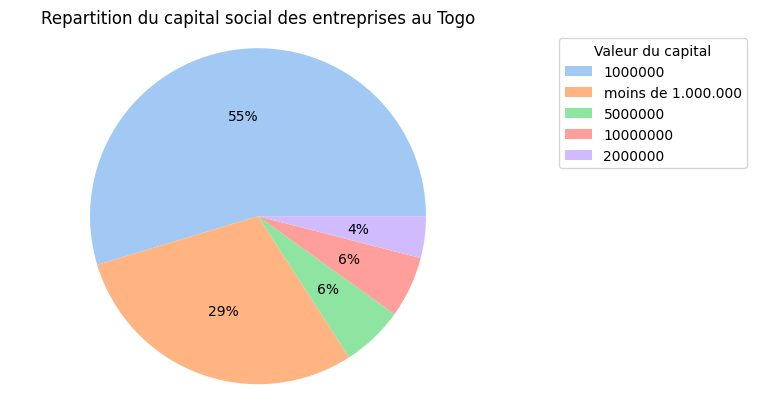

In [39]:
data = df['capital'].value_counts()

plt.pie(data[:5], labels=data[:5].index, autopct='%.0f%%', colors=sns.color_palette('pastel'), labeldistance=None)
plt.title('Repartition du capital social des entreprises au Togo')
plt.legend(title="Valeur du capital", loc="best", bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')
plt.show()

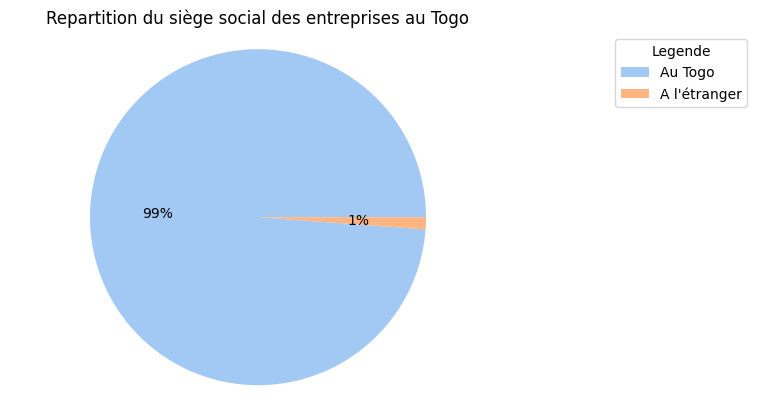

In [40]:
data = df['is_national'].value_counts()

plt.pie(data, labels=['Au Togo', 'A l\'étranger'], autopct='%.0f%%', colors=sns.color_palette('pastel'), labeldistance=None)
plt.title('Repartition du siège social des entreprises au Togo')
plt.legend(title="Legende", loc="best", bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')
plt.show()

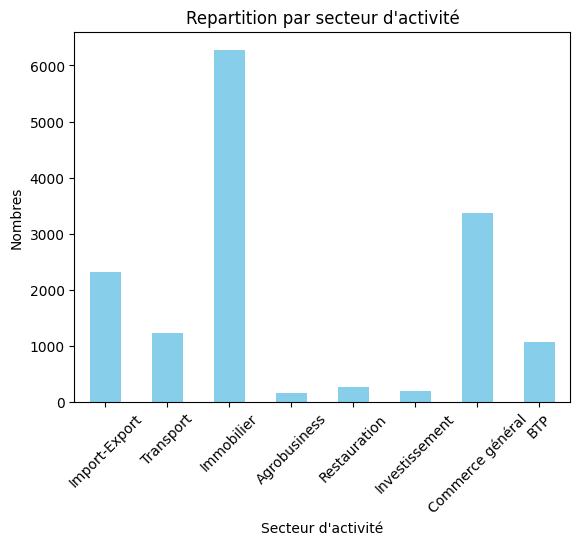

In [41]:
data = df[['is_import_export', 'is_transport', 'is_real_estate', 'is_agrobusiness',
           'is_restoration', 'is_investment', 'is_general_commerce', 'is_BTP']].sum()

data.plot(kind='bar', color='skyblue')
plt.xlabel('Secteur d\'activité')
plt.ylabel('Nombres')
plt.title('Repartition par secteur d\'activité')
plt.xticks(range(0,8), labels=['Import-Export', 'Transport', 'Immobilier', 'Agrobusiness',
           'Restauration', 'Investissement', 'Commerce général', 'BTP'], rotation=45)
plt.show()

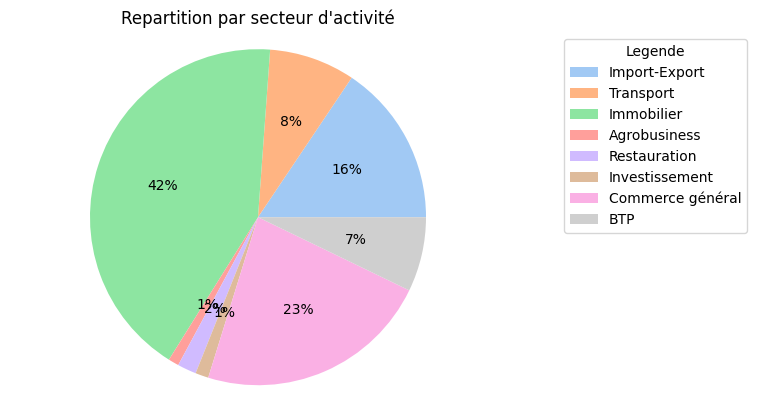

In [42]:
data = df[['is_import_export', 'is_transport', 'is_real_estate', 'is_agrobusiness',
           'is_restoration', 'is_investment', 'is_general_commerce', 'is_BTP']].sum()

plt.pie(data, labels=['Import-Export', 'Transport', 'Immobilier', 'Agrobusiness', 'Restauration', 'Investissement', 'Commerce général', 'BTP'], autopct='%.0f%%', colors=sns.color_palette('pastel'), labeldistance=None)
plt.title('Repartition par secteur d\'activité')
plt.legend(title="Legende", loc="best", bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')
plt.show()

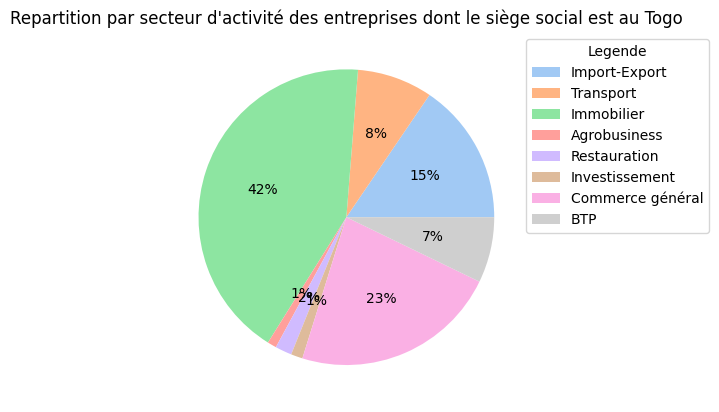

In [178]:
data = df.drop(['name', 'phone_number', 'manager', 'email', 'capital'], axis=1).groupby('is_national').sum()
data.loc[True].plot(kind='pie', ylabel='', autopct='%.0f%%', legend=True, labeldistance=None, colors=sns.color_palette('pastel'), labels=['Import-Export', 'Transport', 'Immobilier', 'Agrobusiness', 'Restauration', 'Investissement', 'Commerce général', 'BTP'])
plt.title('Repartition par secteur d\'activité des entreprises dont le siège social est au Togo')
plt.legend(title="Legende", loc="best", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

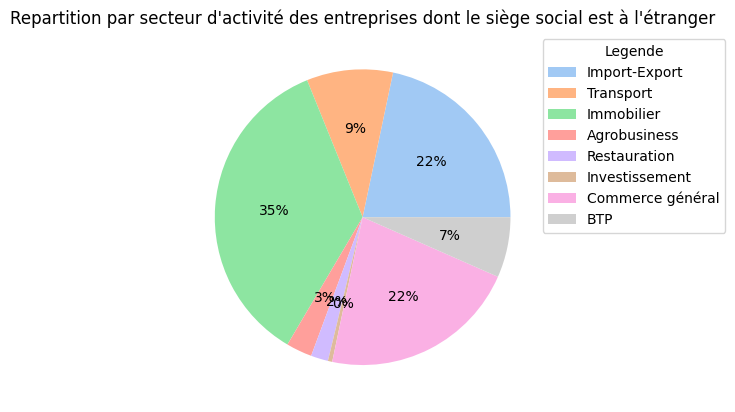

In [179]:
data = df.drop(['name', 'phone_number', 'manager', 'email', 'capital'], axis=1).groupby('is_national').sum()
data.loc[False].plot(kind='pie', ylabel='', autopct='%.0f%%', legend=True, labeldistance=None, colors=sns.color_palette('pastel'), labels=['Import-Export', 'Transport', 'Immobilier', 'Agrobusiness', 'Restauration', 'Investissement', 'Commerce général', 'BTP'])
plt.title('Repartition par secteur d\'activité des entreprises dont le siège social est à l\'étranger')
plt.legend(title="Legende", loc="best", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

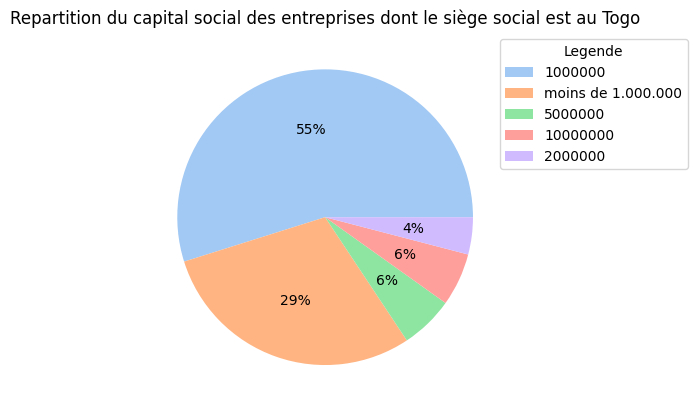

In [180]:
data = df.drop(['name', 'phone_number', 'manager', 'email', 'is_import_export', 'is_transport', 'is_real_estate', 'is_agrobusiness', 'is_restoration', 'is_investment', 'is_general_commerce', 'is_BTP'], axis=1).groupby('is_national').value_counts()
data = data.loc[True][:5]
data.plot(kind='pie', ylabel='', autopct='%.0f%%', legend=True, labeldistance=None, colors=sns.color_palette('pastel'))
plt.title('Repartition du capital social des entreprises dont le siège social est au Togo')
plt.legend(title="Legende", loc="best", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

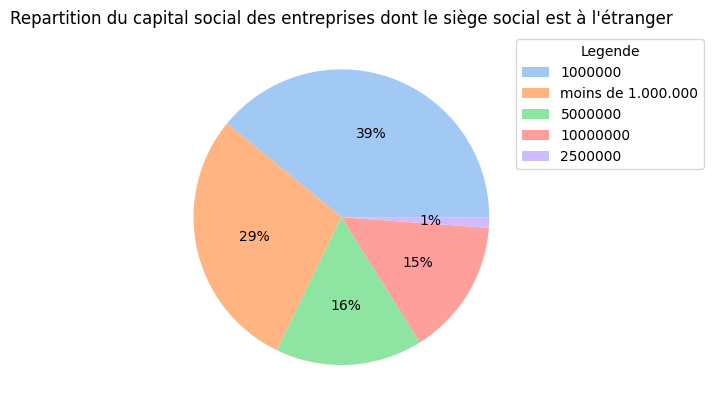

In [181]:
data = df.drop(['name', 'phone_number', 'manager', 'email', 'is_import_export', 'is_transport', 'is_real_estate', 'is_agrobusiness', 'is_restoration', 'is_investment', 'is_general_commerce', 'is_BTP'], axis=1).groupby('is_national').value_counts()
data = data.loc[False][:5]
data.plot(kind='pie', ylabel='', autopct='%.0f%%', legend=True, labeldistance=None, colors=sns.color_palette('pastel'))
plt.title('Repartition du capital social des entreprises dont le siège social est à l\'étranger')
plt.legend(title="Legende", loc="best", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()